# 데이터 셋 다운로드

## 준비

### 라이브러리 호출

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터 셋 로드

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
data_dir

WindowsPath('C:/Users/user/.keras/datasets/flower_photos')

### 데이터 세트 만들기

In [4]:
batch_size = 32
img_height = 180
img_width = 180
image_size=(img_height, img_width)

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 데이터 탐색

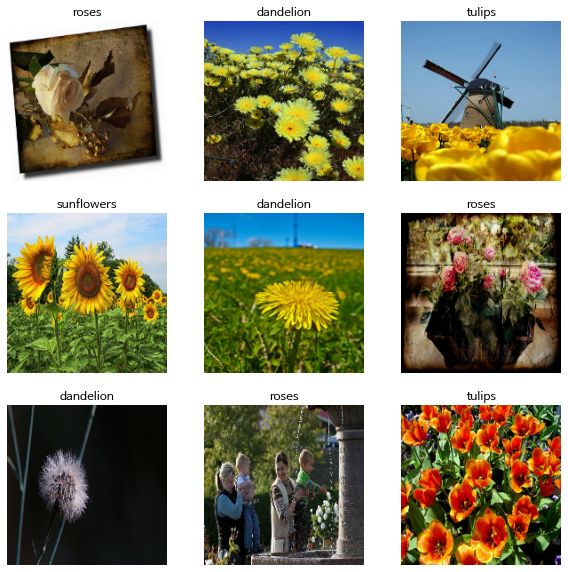

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape) # 텐서의 shape, 마지막의 3은 RGB채널
    print(labels_batch.shape) # 이미지 묶음 개수
    break

(32, 180, 180, 3)
(32,)


## 전처리

### 데이터 표준화

In [10]:
# 표준화를 진행할 수 있는 레이어 정의
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)

### 데이터 튜닝

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 모델링

In [46]:
def build_model():
    x = tf.keras.layers.Input(shape=(180,180,3))
    y = normalization_layer(x)
    y = tf.keras.layers.Conv2D(32, 3, activation='relu')(y)
    y = tf.keras.layers.MaxPooling2D()(y)
    y = tf.keras.layers.Conv2D(32, 3, activation='relu')(y)
    y = tf.keras.layers.MaxPooling2D()(y)
    y = tf.keras.layers.Conv2D(32, 3, activation='relu')(y)
    y = tf.keras.layers.MaxPooling2D()(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(128, activation='relu')(y)
    y = tf.keras.layers.Dense(5)(y)

    model = models.Model(x, y)
    model.compile(
        optimizer='adam',
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['acc'])
    return model
model = build_model()

## 모델 훈련

In [13]:
model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
92/92 [==============================] - 17s 91ms/step - loss: 1.4227 - acc: 0.3632 - val_loss: 1.0560 - val_acc: 0.5804
Epoch 2/5
92/92 [==============================] - 2s 17ms/step - loss: 0.9832 - acc: 0.6026 - val_loss: 0.9793 - val_acc: 0.6131
Epoch 3/5
92/92 [==============================] - 2s 17ms/step - loss: 0.8436 - acc: 0.6735 - val_loss: 0.9261 - val_acc: 0.6022
Epoch 4/5
92/92 [==============================] - 2s 16ms/step - loss: 0.6783 - acc: 0.7333 - val_loss: 0.9685 - val_acc: 0.6240
Epoch 5/5
92/92 [==============================] - 2s 17ms/step - loss: 0.5044 - acc: 0.8128 - val_loss: 1.2076 - val_acc: 0.5899


# tf.data 활용

## 모든 데이터 셋 셔플

In [20]:
image_count = len(list(data_dir.glob('*/*.jpg'))) # 총 이미지 개수
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [21]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


## 데이터 분할

In [37]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size) # 20% 를 넘김
val_ds = list_ds.take(val_size) # 20% 를 가짐 

In [38]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


## image, label 데이터 받기

### 함수 작성

In [39]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [40]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [41]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

### 데이터 생성

In [42]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


## 데이터셋 성능향상 튜닝

In [44]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## 모델 훈련 이어가기

In [45]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
92/92 [==============================] - 3s 21ms/step - loss: 0.5107 - acc: 0.8171 - val_loss: 0.4987 - val_acc: 0.8106
Epoch 2/3
92/92 [==============================] - 2s 18ms/step - loss: 0.2838 - acc: 0.9033 - val_loss: 0.5210 - val_acc: 0.8311
Epoch 3/3
92/92 [==============================] - 2s 18ms/step - loss: 0.1595 - acc: 0.9486 - val_loss: 0.5020 - val_acc: 0.8120


# TensorFlow 데이터세트 이용하기

In [51]:
(train_ds, val_ds, test_ds), info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [52]:
num_classes = info.features['label'].num_classes
print(num_classes)

5


<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=5)>


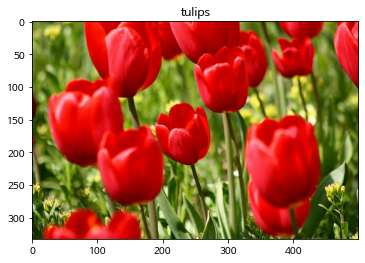

In [54]:
get_label_name = info.features['label'].int2str
print(get_label_name)
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [55]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)